In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
sheet = pd.read_excel('data_input_auto/山东柴油裂解差拟合残差-库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['山东柴油裂解差拟合残差/中国独立炼厂柴油库存'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

山东柴油裂解差拟合残差/中国独立炼厂柴油库存  柴油：社会库存：中国（周）：大样本4周环差  \
2025-05-19                     NaN                    NaN   
2025-05-20                     NaN                    NaN   
2025-05-21                     NaN                    NaN   
2025-05-22                     NaN                    NaN   
2025-05-23                     NaN                    NaN   

            中国柴油实际消费量Seasonal(预测/上一年季节性)  WESTPAC中国经济惊喜指数  螺纹期货价格90日环比  \
2025-05-19                           NaN              NaN          NaN   
2025-05-20                           NaN              NaN          NaN   
2025-05-21                           NaN              NaN          NaN   
2025-05-22                           NaN              NaN          NaN   
2025-05-23                        3.9838              NaN          NaN   

            布伦特原油期货价格30日环比  DR007 - 7天逆回购利率/15DMA90日环差  0#柴油价差（华东-山东）  
2025-05-19             NaN                         NaN            NaN  
2025-05-20             NaN                         NaN            NaN  
2025-05-21             NaN                         NaN            NaN  
2025-05-22             NaN                         NaN            NaN  
2025-05-23             NaN                         NaN            NaN

In [4]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent原油价格_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1['布伦特原油期货价格'] = sheet1['布伦特原油期货价格'].fillna(sheet1['Brent原油期货价格预测'])
    sheet1 = sheet1.drop(columns=['Brent原油期货价格预测'])
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()


,Date,布伦特原油期货价格
513,2023-06-02,76.13
512,2023-06-05,76.71
511,2023-06-06,76.29
510,2023-06-07,76.95
509,2023-06-08,75.96


In [5]:
sheet1 = sheet1.set_index('Date')
sheet = sheet.join(sheet1['布伦特原油期货价格'], how='left')

In [6]:
sheet.columns

Index(['山东柴油裂解差拟合残差/中国独立炼厂柴油库存', '柴油：社会库存：中国（周）：大样本4周环差',
       '中国柴油实际消费量Seasonal(预测/上一年季节性)', 'WESTPAC中国经济惊喜指数', '螺纹期货价格90日环比',
       '布伦特原油期货价格30日环比', 'DR007 - 7天逆回购利率/15DMA90日环差', '0#柴油价差（华东-山东）',
       '布伦特原油期货价格'],
      dtype='object')

In [7]:
################################# 处理缺失值 #################################
fill_methods = {
'柴油：社会库存：中国（周）：大样本4周环差':'interpolate',
'中国柴油实际消费量Seasonal(预测/上一年季节性)':'interpolate', 
'WESTPAC中国经济惊喜指数':'interpolate', 
'螺纹期货价格90日环比':'interpolate',
'布伦特原油期货价格30日环比':'interpolate', 
'DR007 - 7天逆回购利率/15DMA90日环差':'interpolate',
'布伦特原油期货价格':'interpolate',
'0#柴油价差（华东-山东）': 'interpolat'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '山东柴油裂解差拟合残差/中国独立炼厂柴油库存'] = sheet.loc[:last_day, '山东柴油裂解差拟合残差/中国独立炼厂柴油库存'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['柴油：社会库存：中国（周）：大样本4周环差_提前30天'] = sheet['柴油：社会库存：中国（周）：大样本4周环差'].shift(30)
sheet['中国柴油实际消费量Seasonal(预测/上一年季节性)_提前15天'] = sheet['中国柴油实际消费量Seasonal(预测/上一年季节性)'].shift(15)
sheet['WESTPAC中国经济惊喜指数_提前20天'] = sheet['WESTPAC中国经济惊喜指数'].shift(20)
sheet['螺纹期货价格90日环比_提前40天'] = sheet['螺纹期货价格90日环比'].shift(40)
sheet['DR007 - 7天逆回购利率/15DMA90日环差_提前50天'] = sheet['DR007 - 7天逆回购利率/15DMA90日环差'].shift(50)
sheet['0#柴油价差（华东-山东）_提前20天'] = sheet['0#柴油价差（华东-山东）'].shift(20)

sheet['Brent原油期货价格30日环比'] = (sheet['布伦特原油期货价格'] - sheet['布伦特原油期货价格'].shift(30)) / sheet['布伦特原油期货价格'].shift(30)
sheet['布伦特原油期货价格30日环比'] = sheet['布伦特原油期货价格30日环比'].fillna(sheet['Brent原油期货价格30日环比'])

sheet['布伦特原油期货价格30日环比_逆序'] = reverse_column(sheet, '布伦特原油期货价格30日环比')
sheet['Brent原油期货价格30日环比_逆序'] = reverse_column(sheet, 'Brent原油期货价格30日环比')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-03-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['山东柴油裂解差拟合残差/中国独立炼厂柴油库存'].notna())
]

################################# 数据 读取-处理 结束 #################################

未知的填充方法: interpolat


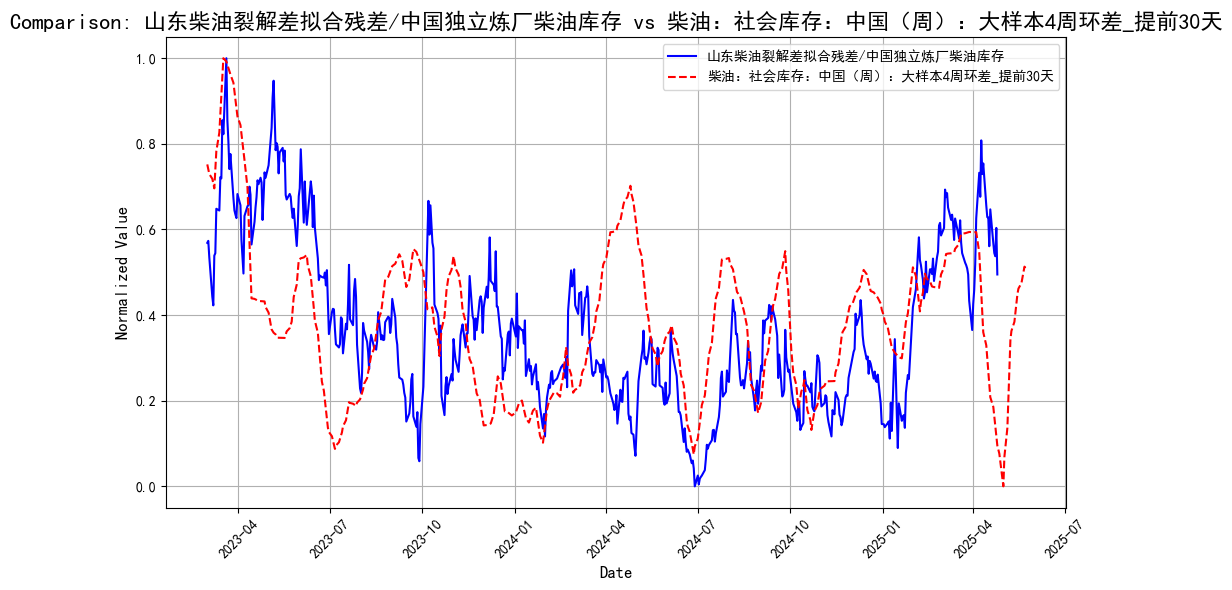

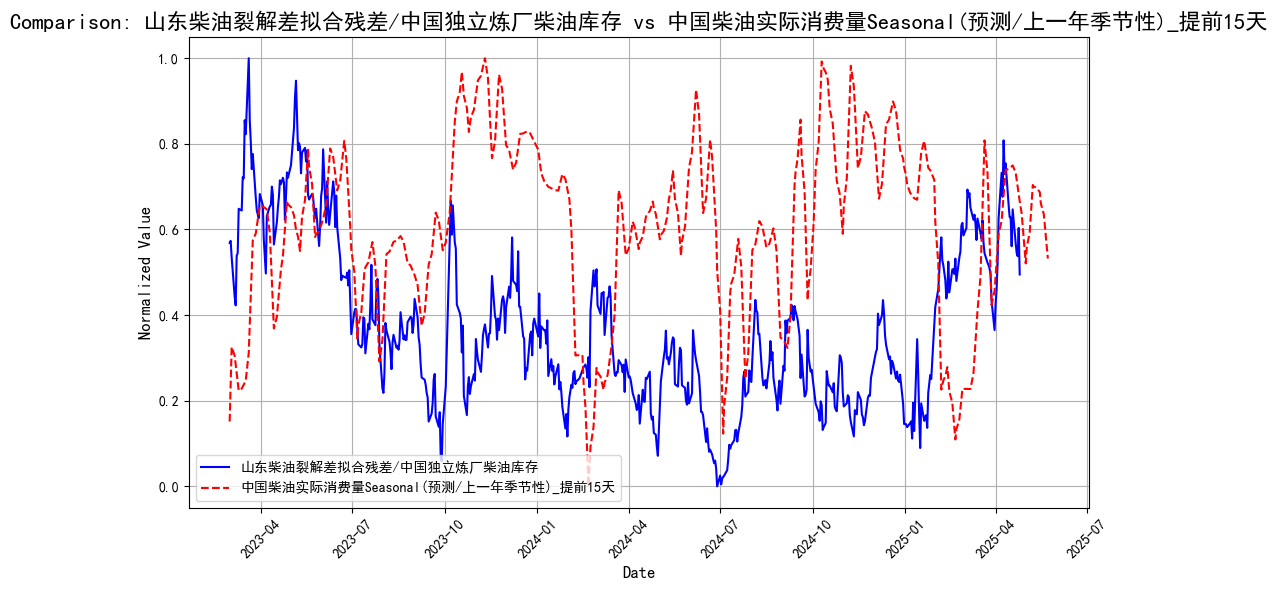

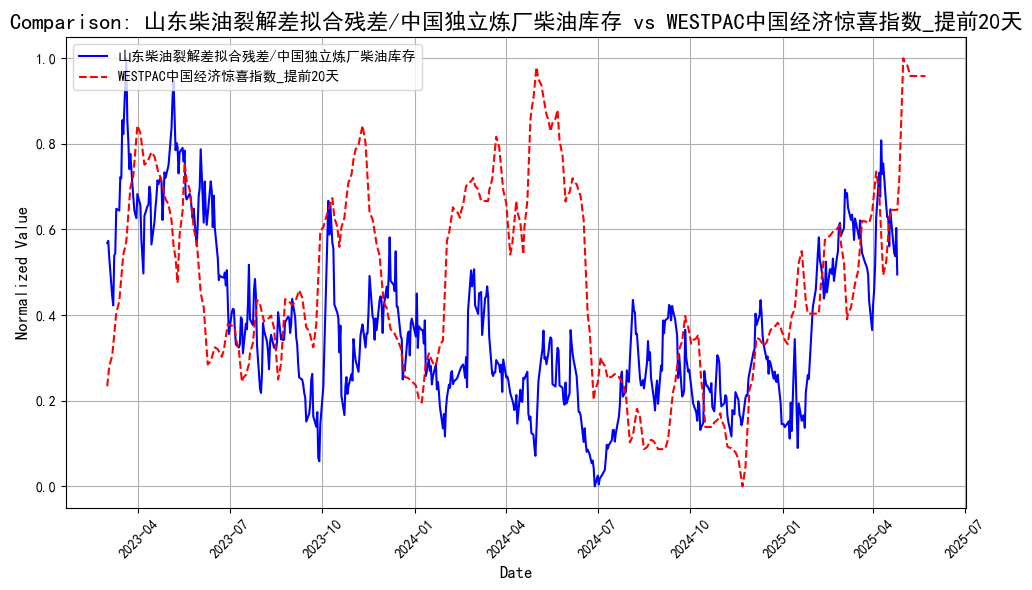

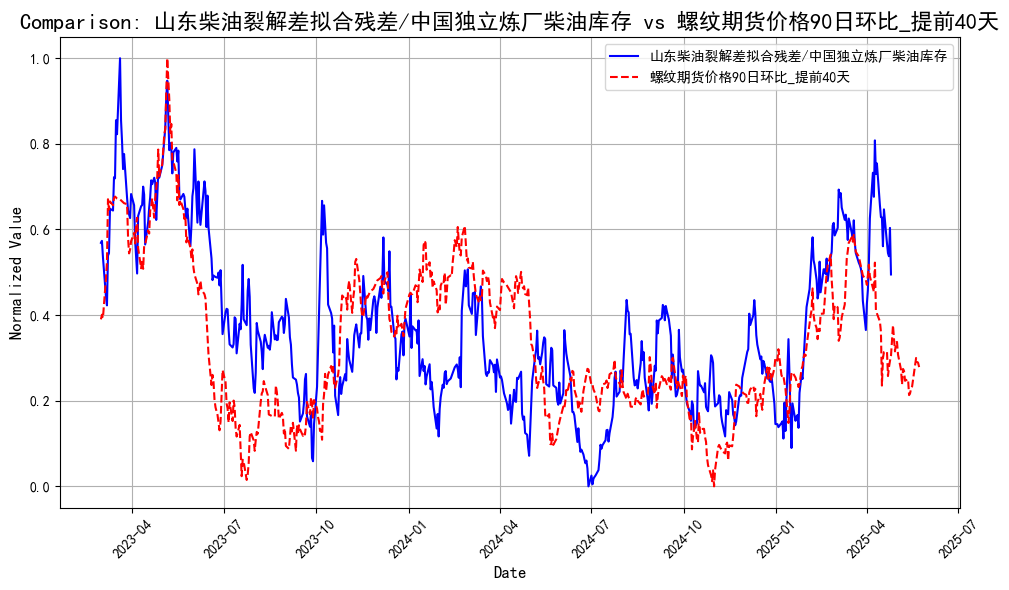

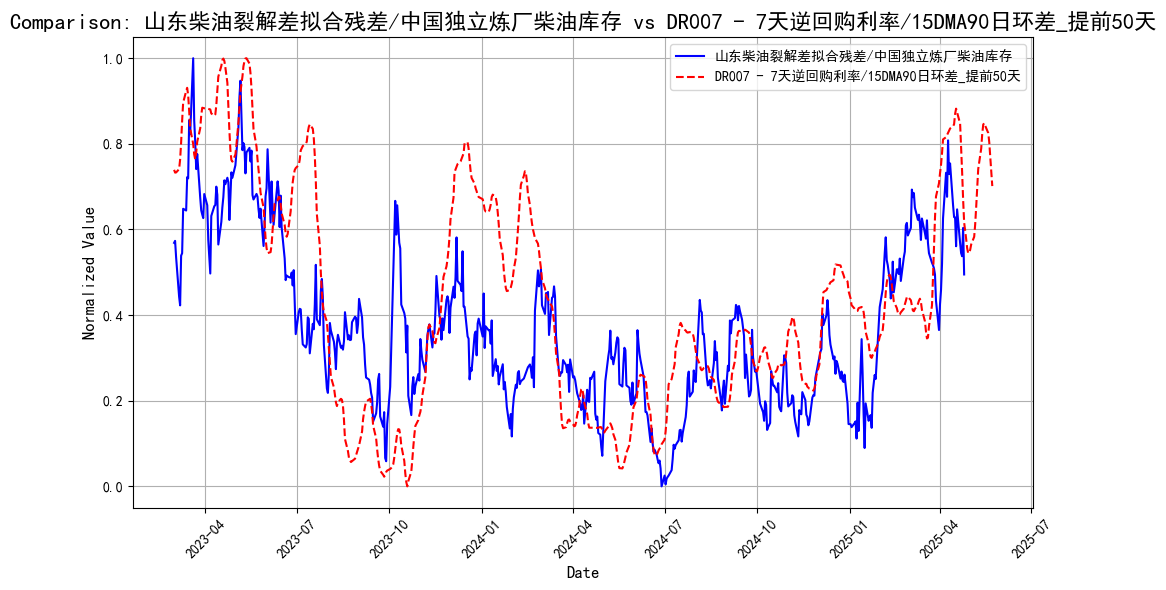

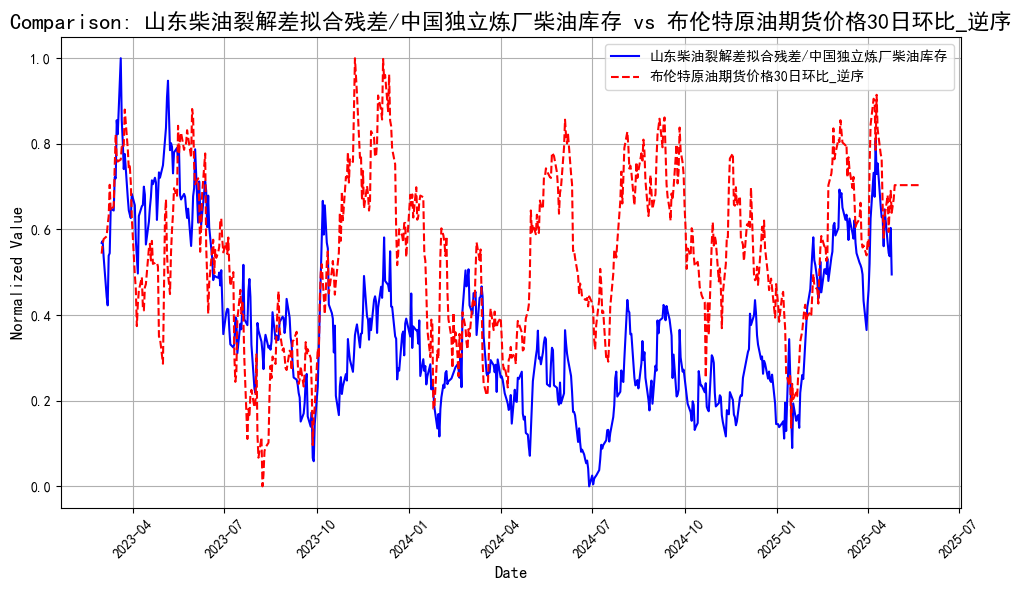

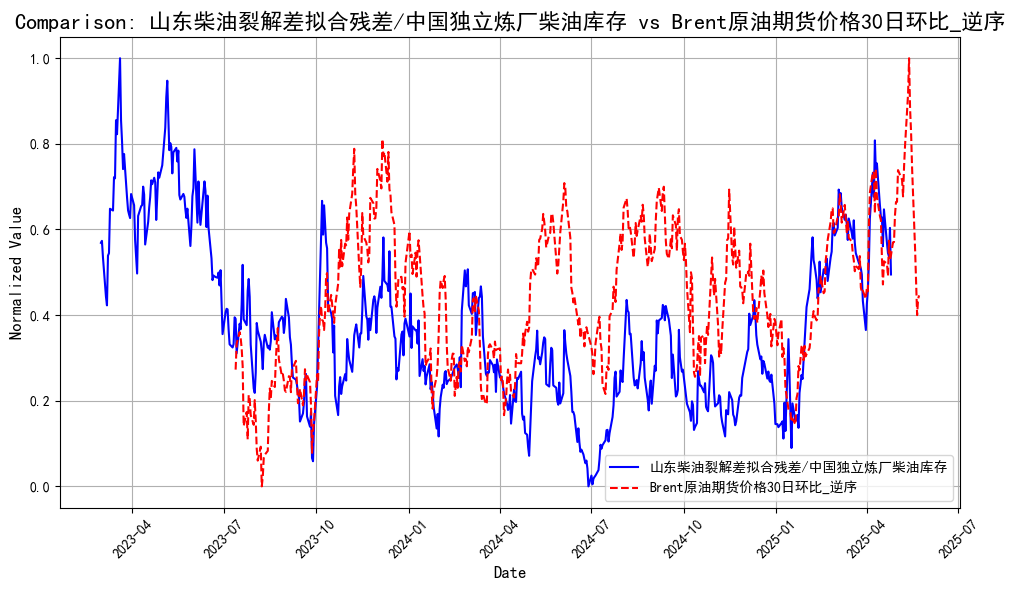

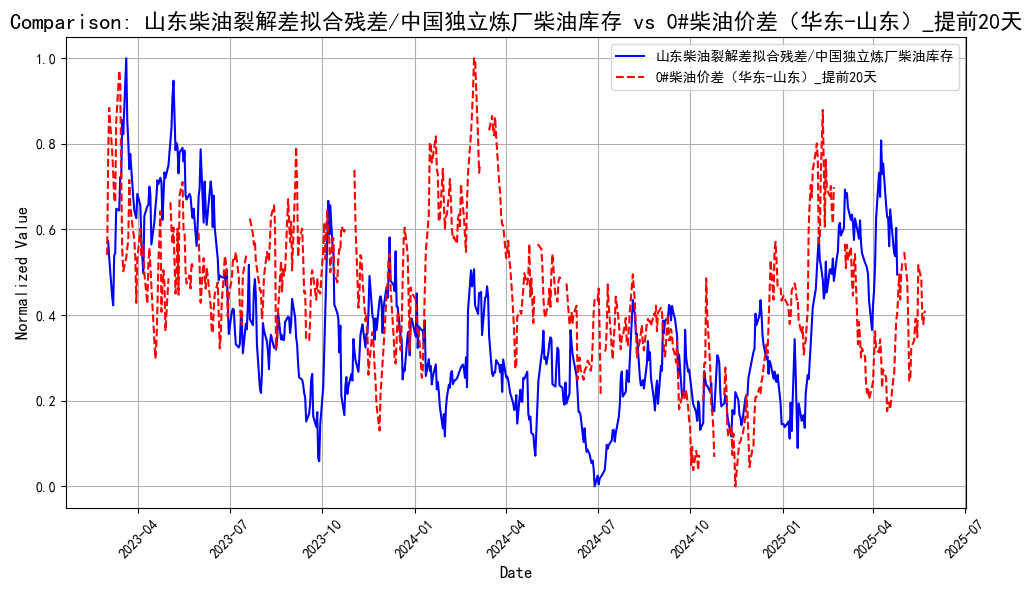

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='山东柴油裂解差拟合残差/中国独立炼厂柴油库存', 
    compare_cols=[
        '柴油：社会库存：中国（周）：大样本4周环差_提前30天',
        '中国柴油实际消费量Seasonal(预测/上一年季节性)_提前15天',
        'WESTPAC中国经济惊喜指数_提前20天',
        '螺纹期货价格90日环比_提前40天',
        'DR007 - 7天逆回购利率/15DMA90日环差_提前50天',
        '布伦特原油期货价格30日环比_逆序',
        'Brent原油期货价格30日环比_逆序',
        '0#柴油价差（华东-山东）_提前20天'
        ]
)

In [9]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 1
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '柴油：社会库存：中国（周）：大样本4周环差_提前30天',
        '中国柴油实际消费量Seasonal(预测/上一年季节性)_提前15天',
        'WESTPAC中国经济惊喜指数_提前20天',
        '螺纹期货价格90日环比_提前40天',
        'DR007 - 7天逆回购利率/15DMA90日环差_提前50天',
        '布伦特原油期货价格30日环比_逆序',
#        'Brent原油期货价格30日环比_逆序',
        '0#柴油价差（华东-山东）_提前20天'
]

predict_column = '山东柴油裂解差拟合残差/中国独立炼厂柴油库存'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.09757370413389559, 
    'max_depth': 8, 
    'min_child_weight': 4.1008004735022965, 
    'subsample': 0.8610994899956461, 
    'colsample_bytree': 0.9139037883806105, 
    'gamma': 0.4950927575220668, 
    'reg_alpha': 0.3033827082937904, 
    'reg_lambda': 0.5469780761303527,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
#    'tree_method': 'auto'
}


num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:170.64358	train-rmse:218.14146


[500]	eval-rmse:16.59689	train-rmse:0.85384


[1000]	eval-rmse:16.56898	train-rmse:0.61123


[1500]	eval-rmse:16.56921	train-rmse:0.56332

[2000]	eval-rmse:56.48619	train-rmse:0.52045


[2000]	eval-rmse:16.52602	train-rmse:0.53930


[2500]	eval-rmse:16.53073	train-rmse:0.52661

[3914]	eval-rmse:56.46364	train-rmse:0.49761


[2657]	eval-rmse:16.52186	train-rmse:0.52516


训练集 MSE (DMatrix): 0.3468, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 272.9717, 测试集 R² (DMatrix): nan


C:\Users\wxqp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


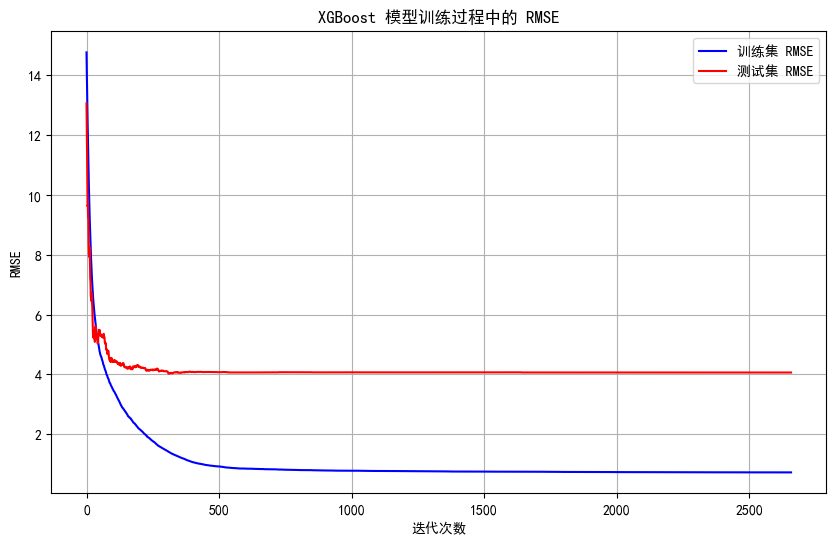

In [10]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:218.37624


[500]	train-rmse:0.76447


[1000]	train-rmse:0.58907


[1500]	train-rmse:0.55783


[2000]	train-rmse:0.53363


[2500]	train-rmse:0.51766


[3000]	train-rmse:0.50906


[3500]	train-rmse:0.50681


[3508]	train-rmse:0.50682


全部数据 MSE: 0.3087, 全部数据 R²: 1.0

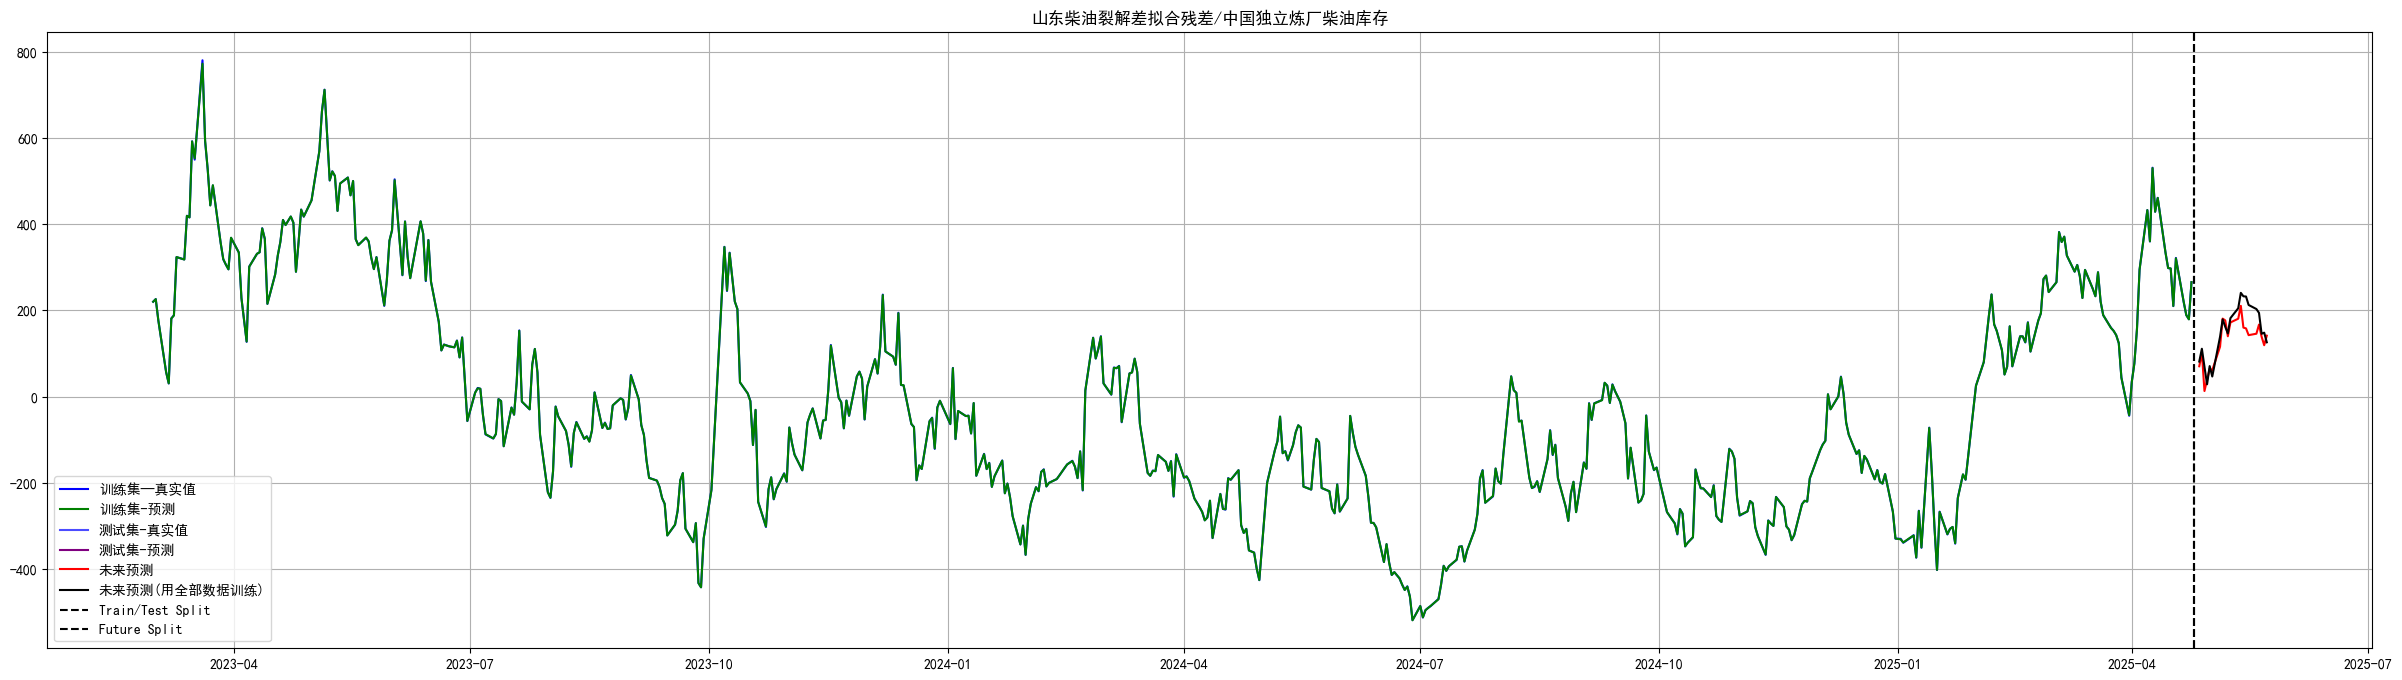

In [12]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('山东柴油裂解差拟合残差/中国独立炼厂柴油库存')
plt.legend()
plt.grid(True)
plt.show()

---

In [13]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/柴油裂解差拟合残差-库存_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily.head()

,Date,真实值,预测值
597,2025/05/23,NaN,125.903961
596,2025/05/22,NaN,148.269943
595,2025/05/21,NaN,145.646927
594,2025/05/20,NaN,194.139313
593,2025/05/19,NaN,203.063339


In [14]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/柴油裂解差拟合残差-库存_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
26,2025/05/31,NaN,168.538437
25,2025/04/30,274.354087,238.465729
24,2025/03/31,231.396181,231.464615
23,2025/02/28,155.579145,155.607712
22,2025/01/31,-244.945645,-244.959183


In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东柴油裂解差拟合残差/中国独立炼厂柴油库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东柴油裂解差拟合残差/中国独立炼厂柴油库存"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
